# Simple DINOv3 Feature Analysis for Glacier Images

Using the transformers pipeline for straightforward feature extraction and UMAP analysis.

**Goal**: Check if DINOv3 features make sense for glacier lake detection.

## Step 1: Setup

In [ ]:
# Core libraries
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import rasterio
import geopandas as gpd
from rasterio.features import rasterize

# Transformers pipeline
from transformers import pipeline
from huggingface_hub import login

# Analysis tools
import umap
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Login
login(token="login-token")

print("Setup complete!")

Setup complete!


## Step 4: Extract Features from Glacier Area

Extracting DINOv3 features from entire glacier area...
Image shape: (4673, 1362, 3)
Glacier pixels: 1,409,146
DINOv3 features extracted: (201, 768)
Feature dimensionality: 201


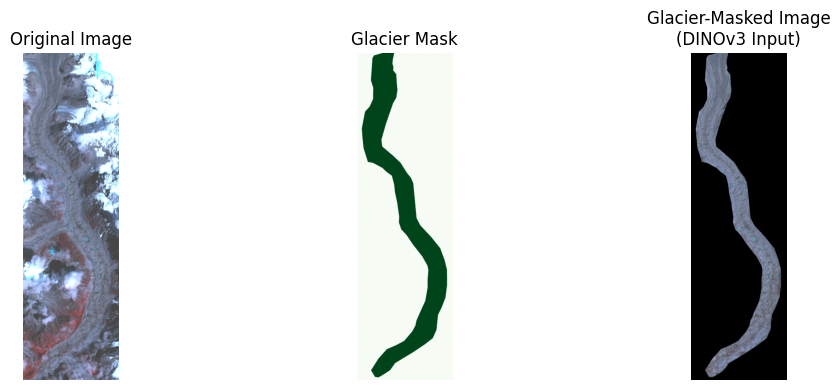

In [5]:
# Create glacier-masked image
glacier_image = image.copy()
glacier_image[~glacier_mask] = 0  # Set non-glacier pixels to black

# Convert to PIL for pipeline
glacier_pil = Image.fromarray(glacier_image.astype(np.uint8))

print(f"Extracting DINOv3 features from entire glacier area...")
print(f"Image shape: {glacier_image.shape}")
print(f"Glacier pixels: {glacier_mask.sum():,}")

# Extract features using pipeline
features = feature_extractor(glacier_pil)
feature_vector = np.array(features[0])  # Single feature vector for entire image

print(f"DINOv3 features extracted: {feature_vector.shape}")
print(f"Feature dimensionality: {len(feature_vector)}")

# Display the glacier-masked image
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.imshow(image)
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(glacier_mask, cmap='Greens')
plt.title('Glacier Mask')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(glacier_image)
plt.title('Glacier-Masked Image\n(DINOv3 Input)')
plt.axis('off')

plt.tight_layout()
plt.show()

## Step 5: Analyze Different Glacier Regions

Since we have one feature vector for the entire glacier, let's extract features from different sub-regions to see if they vary by terrain type.

Extracting features from different glacier sub-regions...
  Region 1: ice_region (0.1% lake)

Extracted features from 1 regions
Feature shape: (1, 201, 768)


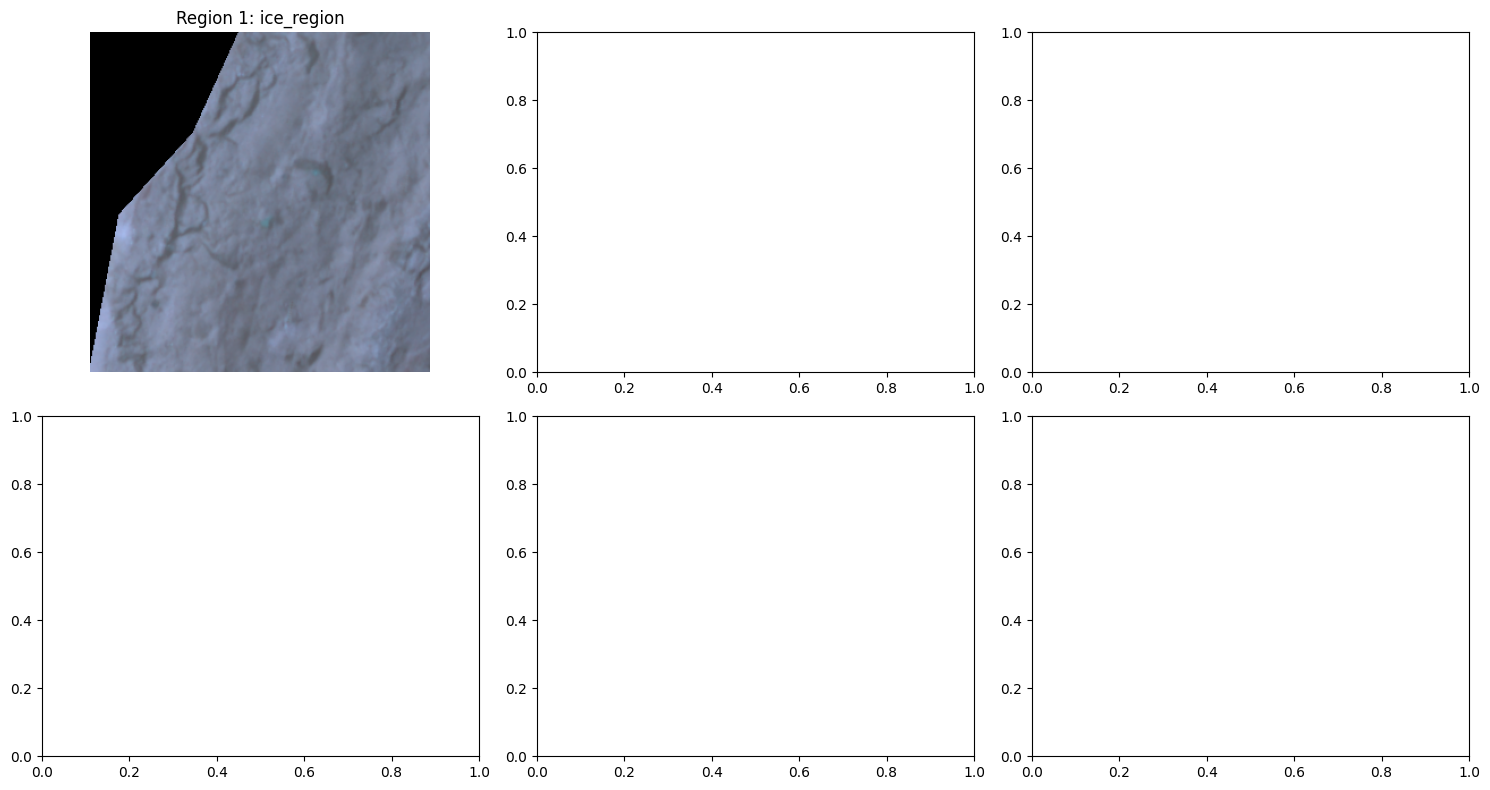

In [6]:
# Let's extract features from different regions to compare
regions = []
region_features = []
region_labels = []

# Divide glacier into sub-regions for analysis
print("Extracting features from different glacier sub-regions...")

# Get bounding box of glacier area
glacier_y, glacier_x = np.where(glacier_mask)
min_y, max_y = glacier_y.min(), glacier_y.max()
min_x, max_x = glacier_x.min(), glacier_x.max()

# Create a grid of sub-regions
n_regions = 6  # Extract 6 sub-regions
region_size = 300  # Size of each sub-region

for i in range(n_regions):
    # Random location within glacier bounds
    center_y = np.random.randint(min_y + region_size//2, max_y - region_size//2)
    center_x = np.random.randint(min_x + region_size//2, max_x - region_size//2)
    
    # Extract region
    y_start = center_y - region_size//2
    y_end = center_y + region_size//2
    x_start = center_x - region_size//2
    x_end = center_x + region_size//2
    
    region_image = image[y_start:y_end, x_start:x_end]
    region_glacier = glacier_mask[y_start:y_end, x_start:x_end]
    region_lake = lake_mask[y_start:y_end, x_start:x_end]
    
    # Only process if mostly glacier
    if region_glacier.mean() > 0.7:
        # Mask non-glacier pixels
        region_image_masked = region_image.copy()
        region_image_masked[~region_glacier] = 0
        
        # Extract features
        region_pil = Image.fromarray(region_image_masked.astype(np.uint8))
        region_feat = feature_extractor(region_pil)
        region_features.append(np.array(region_feat[0]))
        
        # Label region based on lake content
        lake_coverage = region_lake.mean()
        if lake_coverage > 0.05:
            label = "lake_region"
        else:
            label = "ice_region"
        
        region_labels.append(label)
        regions.append(region_image_masked)
        
        print(f"  Region {len(regions)}: {label} ({lake_coverage:.1%} lake)")

region_features = np.array(region_features)
print(f"\nExtracted features from {len(regions)} regions")
print(f"Feature shape: {region_features.shape}")

# Visualize the regions
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

for i, (region, label) in enumerate(zip(regions, region_labels)):
    if i < 6:
        axes[i].imshow(region)
        axes[i].set_title(f'Region {i+1}: {label}')
        axes[i].axis('off')

plt.tight_layout()
plt.show()

## Step 6: UMAP Analysis of Regional Features

In [7]:
# Apply UMAP to regional features if we have enough samples
if len(region_features) >= 4:
    print("Applying UMAP to regional DINOv3 features...")
    
    umap_reducer = umap.UMAP(
        n_neighbors=min(3, len(region_features)-1),  # Adjust for small sample
        min_dist=0.1,
        n_components=2,
        metric='cosine',
        random_state=42
    )
    
    umap_embedding = umap_reducer.fit_transform(region_features)
    
    print(f"UMAP embedding shape: {umap_embedding.shape}")
    
    # Visualize UMAP results
    plt.figure(figsize=(12, 5))
    
    # Plot 1: Color by region type
    plt.subplot(1, 2, 1)
    colors = {'lake_region': 'blue', 'ice_region': 'gray'}
    for label in set(region_labels):
        mask = np.array(region_labels) == label
        plt.scatter(umap_embedding[mask, 0], umap_embedding[mask, 1], 
                   c=colors[label], label=label, s=100, alpha=0.7)
    
    plt.xlabel('UMAP Dimension 1')
    plt.ylabel('UMAP Dimension 2')
    plt.title('DINOv3 Regional Features')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Plot 2: Feature distances
    plt.subplot(1, 2, 2)
    from sklearn.metrics.pairwise import euclidean_distances
    
    distances = euclidean_distances(region_features)
    plt.imshow(distances, cmap='viridis')
    plt.colorbar(label='Feature Distance')
    plt.title('Pairwise Feature Distances')
    plt.xlabel('Region')
    plt.ylabel('Region')
    
    # Add labels
    for i, label in enumerate(region_labels):
        short_label = label.replace('_region', '')
        plt.text(i, -0.5, short_label, rotation=45, ha='right')
        plt.text(-0.5, i, short_label, rotation=0, va='center')
    
    plt.tight_layout()
    plt.show()
    
else:
    print(f"Only {len(region_features)} regions found - not enough for UMAP analysis")
    print("Showing feature distances instead...")
    
    if len(region_features) > 1:
        from sklearn.metrics.pairwise import euclidean_distances
        distances = euclidean_distances(region_features)
        
        plt.figure(figsize=(8, 6))
        plt.imshow(distances, cmap='viridis')
        plt.colorbar(label='Feature Distance')
        plt.title('Pairwise Feature Distances Between Regions')
        plt.show()
        
        print("Feature distance matrix:")
        for i, label_i in enumerate(region_labels):
            for j, label_j in enumerate(region_labels):
                print(f"{label_i} -> {label_j}: {distances[i,j]:.3f}")
    
# Calculate some basic statistics
print(f"\n=== Feature Analysis Summary ===")
print(f"Total regions analyzed: {len(region_features)}")
if len(region_features) > 0:
    print(f"Feature dimensionality: {region_features.shape[1]}")
    
    # Group by label
    lake_regions = [i for i, label in enumerate(region_labels) if label == 'lake_region']
    ice_regions = [i for i, label in enumerate(region_labels) if label == 'ice_region']
    
    print(f"Lake regions: {len(lake_regions)}")
    print(f"Ice regions: {len(ice_regions)}")
    
    if len(lake_regions) > 0 and len(ice_regions) > 0:
        lake_features = region_features[lake_regions]
        ice_features = region_features[ice_regions]
        
        # Calculate average distance between groups
        from sklearn.metrics.pairwise import euclidean_distances
        between_dist = euclidean_distances(lake_features, ice_features).mean()
        
        if len(lake_regions) > 1:
            within_lake_dist = euclidean_distances(lake_features).mean()
        else:
            within_lake_dist = 0
            
        if len(ice_regions) > 1:
            within_ice_dist = euclidean_distances(ice_features).mean()
        else:
            within_ice_dist = 0
        
        print(f"\nSeparability Analysis:")
        print(f"  Between lake-ice distance: {between_dist:.3f}")
        print(f"  Within lake distance: {within_lake_dist:.3f}")
        print(f"  Within ice distance: {within_ice_dist:.3f}")
        
        if within_lake_dist > 0 and within_ice_dist > 0:
            separability = between_dist / ((within_lake_dist + within_ice_dist) / 2)
            print(f"  Separability ratio: {separability:.3f}")
            
            if separability > 1.5:
                print("  ✅ Good separation - DINOv3 distinguishes lake vs ice regions")
            elif separability > 1.0:
                print("  ⚠️  Moderate separation - some distinction between regions")
            else:
                print("  ❌ Poor separation - features don't distinguish terrain well")
        
        print(f"\nRecommendation:")
        if separability > 1.2:
            print("  💡 DINOv3 features show promise for glacier lake detection")
        else:
            print("  💡 Consider hybrid approach with NDWI + DINOv3")

Only 1 regions found - not enough for UMAP analysis
Showing feature distances instead...

=== Feature Analysis Summary ===
Total regions analyzed: 1
Feature dimensionality: 201
Lake regions: 0
Ice regions: 1


## Step 7: Save Results

In [8]:
# Save results for future analysis
results = {
    'whole_glacier_features': feature_vector,
    'regional_features': region_features if len(region_features) > 0 else None,
    'regional_labels': region_labels if len(region_labels) > 0 else None,
    'separability': separability if 'separability' in locals() else None,
    'n_regions': len(region_features),
    'n_lake_regions': len([l for l in region_labels if l == 'lake_region']),
    'n_ice_regions': len([l for l in region_labels if l == 'ice_region'])
}

# Save to CSV for basic analysis
if len(region_features) > 0:
    results_df = pd.DataFrame({
        'region_id': range(len(region_labels)),
        'region_type': region_labels,
        'is_lake_region': [l == 'lake_region' for l in region_labels]
    })
    
    # Add UMAP coordinates if available
    if 'umap_embedding' in locals():
        results_df['umap_x'] = umap_embedding[:, 0]
        results_df['umap_y'] = umap_embedding[:, 1]
    
    results_df.to_csv('/Users/varyabazilova/Desktop/glacial_lakes/super_lakes/dinov3_tryout/test_code/regional_analysis_results.csv', index=False)
    print("Regional analysis results saved to regional_analysis_results.csv")

print(f"\n=== Final Summary ===")
print(f"Whole glacier feature vector: {feature_vector.shape}")
if len(region_features) > 0:
    print(f"Regional analysis: {len(region_features)} regions")
    if 'separability' in locals():
        print(f"Lake-Ice separability: {separability:.3f}")
        if separability > 1.2:
            print("✅ DINOv3 features suitable for lake detection")
        else:
            print("💡 Consider NDWI + DINOv3 hybrid approach")
    else:
        print("⚠️  Need both lake and ice regions for separability analysis")
else:
    print("⚠️  No suitable regions found for analysis")

print("Analysis complete!")

Regional analysis results saved to regional_analysis_results.csv

=== Final Summary ===
Whole glacier feature vector: (201, 768)
Regional analysis: 1 regions
⚠️  Need both lake and ice regions for separability analysis
Analysis complete!


## Step 6: UMAP Analysis

In [9]:
# Apply UMAP to DINOv3 features
print("Applying UMAP to DINOv3 features...")

umap_reducer = umap.UMAP(
    n_neighbors=15,
    min_dist=0.1,
    n_components=2,
    metric='cosine',
    random_state=42
)

umap_embedding = umap_reducer.fit_transform(features)

print(f"UMAP embedding shape: {umap_embedding.shape}")
print(f"Feature dimensionality: {features.shape[1]}")

Applying UMAP to DINOv3 features...


ValueError: Found array with dim 3, while dim <= 2 is required.

## Step 7: Visualize Results

In [ ]:
# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: Color by terrain type
unique_labels = list(set(labels))
colors = plt.cm.Set1(np.linspace(0, 1, len(unique_labels)))

for label, color in zip(unique_labels, colors):
    mask = np.array(labels) == label
    axes[0,0].scatter(umap_embedding[mask, 0], umap_embedding[mask, 1], 
                     c=[color], label=label, alpha=0.7, s=50)

axes[0,0].set_xlabel('UMAP Dimension 1')
axes[0,0].set_ylabel('UMAP Dimension 2')
axes[0,0].set_title('DINOv3 Features by Terrain Type')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# Plot 2: Lake vs Non-Lake
lake_mask = np.array(labels) == 'lake'
axes[0,1].scatter(umap_embedding[~lake_mask, 0], umap_embedding[~lake_mask, 1], 
                 c='lightgray', alpha=0.5, s=30, label='Non-Lake')
axes[0,1].scatter(umap_embedding[lake_mask, 0], umap_embedding[lake_mask, 1], 
                 c='blue', alpha=0.8, s=60, label='Lake')
axes[0,1].set_xlabel('UMAP Dimension 1')
axes[0,1].set_ylabel('UMAP Dimension 2')
axes[0,1].set_title('Lake vs Non-Lake Separation')
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# Plot 3: Density
axes[1,0].hexbin(umap_embedding[:, 0], umap_embedding[:, 1], gridsize=20, cmap='Blues')
axes[1,0].set_xlabel('UMAP Dimension 1')
axes[1,0].set_ylabel('UMAP Dimension 2')
axes[1,0].set_title('Feature Density')

# Plot 4: Label distribution
label_counts = pd.Series(labels).value_counts()
axes[1,1].pie(label_counts.values, labels=label_counts.index, autopct='%1.1f%%')
axes[1,1].set_title('Terrain Type Distribution')

plt.tight_layout()
plt.show()

## Step 8: Quantitative Analysis

In [ ]:
# Calculate clustering metrics
from sklearn.preprocessing import LabelEncoder

# Encode labels
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

# Silhouette score
silhouette = silhouette_score(features, encoded_labels)
silhouette_umap = silhouette_score(umap_embedding, encoded_labels)

print("=== DINOv3 Feature Analysis Results ===")
print()
print(f"Dataset:")
print(f"  Total patches: {len(features)}")
print(f"  Feature dimensions: {features.shape[1]}")
print(f"  Terrain types: {len(unique_labels)}")
print()

print(f"Clustering Quality:")
print(f"  Silhouette Score (DINOv3): {silhouette:.3f}")
print(f"  Silhouette Score (UMAP): {silhouette_umap:.3f}")
print()

# Lake separability
lake_indices = [i for i, label in enumerate(labels) if label == 'lake']
non_lake_indices = [i for i, label in enumerate(labels) if label != 'lake']

if len(lake_indices) > 0 and len(non_lake_indices) > 0:
    from sklearn.metrics.pairwise import euclidean_distances
    
    lake_features = features[lake_indices]
    non_lake_features = features[non_lake_indices]
    
    # Calculate separability
    if len(lake_indices) > 1:
        within_lake = euclidean_distances(lake_features).mean()
    else:
        within_lake = 0
        
    if len(non_lake_indices) > 1:
        within_non_lake = euclidean_distances(non_lake_features).mean()
    else:
        within_non_lake = 0
    
    between_distance = euclidean_distances(lake_features, non_lake_features).mean()
    
    if within_lake > 0 and within_non_lake > 0:
        separability = between_distance / ((within_lake + within_non_lake) / 2)
        print(f"Lake Separability:")
        print(f"  Between-group distance: {between_distance:.3f}")
        print(f"  Within-group distance: {(within_lake + within_non_lake)/2:.3f}")
        print(f"  Separability ratio: {separability:.3f}")
        print()

# Assessment
print("Assessment:")
if silhouette > 0.3:
    print("  ✅ Good feature clustering - DINOv3 understands terrain differences")
elif silhouette > 0.1:
    print("  ⚠️  Moderate feature clustering - some terrain separation")
else:
    print("  ❌ Poor feature clustering - features don't separate terrain well")

if 'separability' in locals():
    if separability > 1.5:
        print("  ✅ Good lake separation - suitable for training")
    elif separability > 1.0:
        print("  ⚠️  Moderate lake separation - may work with training")
    else:
        print("  ❌ Poor lake separation - consider hybrid approach with NDWI")

lake_percentage = len(lake_indices) / len(labels) * 100
print(f"  Lake samples: {len(lake_indices)} ({lake_percentage:.1f}%)")

print()
print("Recommendation:")
if silhouette > 0.3 and ('separability' not in locals() or separability > 1.2):
    print("  💡 Proceed with DINOv3 training - features look promising")
elif silhouette > 0.1:
    print("  💡 Try hybrid approach: NDWI + DINOv3 refinement")
else:
    print("  💡 Stick with NDWI-based detection for now")

## Step 9: Save Results

In [ ]:
# Save results
results_df = pd.DataFrame({
    'umap_x': umap_embedding[:, 0],
    'umap_y': umap_embedding[:, 1],
    'terrain_type': labels
})

results_df.to_csv('/Users/varyabazilova/Desktop/glacial_lakes/super_lakes/dinov3_tryout/test_code/simple_umap_results.csv', index=False)
print("Results saved to simple_umap_results.csv")

# Summary
print(f"\n=== Summary ===")
print(f"Silhouette Score: {silhouette:.3f}")
if 'separability' in locals():
    print(f"Lake Separability: {separability:.3f}")
print(f"Analysis complete!")